In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
import io
import string
import warnings
import seaborn as sns
warnings.simplefilter('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gangxinli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Load the file

Time consuming: ~ 10min

Load the dataset and be familar with the description content

In [2]:
file_path = './technical_test_data.json'

Data = pd.read_json(file_path)
Data


,id,Description,tags,created_at,cc_emails,fwd_emails,reply_cc_emails,ticket_cc_emails,fr_escalated,spam,...,priority,requester_id,responder_id,source,company_id,status,subject,association_type,support_email,to_emails
0,0,"- __EMAIL__ Hi , I have just ordered a pair of...","[category-1, missing-items, field-1456]",2020-03-15,[],[],[],[],False,False,...,1,30,304,1,None,5,Customer Request,None,digitalgenius.com,['support@digitalgenius.com']
1,1,I am missing a pair of shoes from my order. Co...,"[missing-items, open-ticket]",2021-01-18,[],[],[],[],False,False,...,1,30,304,1,None,5,Customer Request,None,digitalgenius.com,['support@digitalgenius.com']
2,2,I didn'tget a my order - __EMAIL__,"[category-1, missing-items]",2019-08-01,[],[],[],[],False,False,...,1,30,304,1,None,5,Customer Request,None,digitalgenius.com,['support@digitalgenius.com']
3,3,"Hello, I ordered two __PRODUCTS_NAMES and one ...","[category-1, missing-items, open-ticket, field...",2020-08-27,[],[],[],[],False,False,...,1,30,304,1,None,5,Customer Request,None,digitalgenius.com,['support@digitalgenius.com']
4,4,My shipment never was delivered. The tracking ...,"[category-1, missing-items, open-ticket]",2019-07-21,[],[],[],[],False,False,...,1,30,304,1,None,5,Customer Request,None,digitalgenius.com,['support@digitalgenius.com']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1428,1428,Subscription Do you have to send back containe...,"[category-1, cancel-subscription, open-ticket]",2021-01-29,[],[],[],[],False,False,...,1,30,304,1,None,5,Customer Request,None,digitalgenius.com,['support@digitalgenius.com']
1429,1429,"PLEASE CANCEL ANY SUBSCRIPTION I HAVE, PLEASE ...","[category-1, cancel-subscription]",2019-10-16,[],[],[],[],False,False,...,1,30,304,1,None,5,Customer Request,None,digitalgenius.com,['support@digitalgenius.com']
1430,1430,Return a scent for different one. And cancel s...,"[category-1, ticket, cancel-subscription]",2021-01-17,[],[],[],[],False,False,...,1,30,304,1,None,5,Customer Request,None,digitalgenius.com,['support@digitalgenius.com']
1431,1431,Canceling subscription I need to cancel my sub...,"[category-1, cancel-subscription, open-ticket]",2019-09-28,[],[],[],[],False,False,...,1,30,304,1,None,5,Customer Request,None,digitalgenius.com,['support@digitalgenius.com']


In [3]:
# Check the details content
item = 88
Data['Description'][item],Data['tags'][item]
# 'where-is-my-order' is the missing tag

('Hello,\n \n\n I placed an order on __DATE____ORDER_NUMBER__. When placing the order, the shipping time was listed as 1-2 days. It has now been 10 days and I have not received a shipping notification. Just wondering what the status of my order is. I have attempted contacting on livechat during listed hours and it is never available. I have tried calling and never get my call answered so hoping I will get a response via email.\n \n\n Thanks. - __EMAIL__',
 ['category-1', 'where-is-my-order', 'open-ticket', 'field-1456'])

In [4]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                1433 non-null   int64         
 1   Description       1433 non-null   object        
 2   tags              1433 non-null   object        
 3   created_at        1433 non-null   datetime64[ns]
 4   cc_emails         1433 non-null   object        
 5   fwd_emails        1433 non-null   object        
 6   reply_cc_emails   1433 non-null   object        
 7   ticket_cc_emails  1433 non-null   object        
 8   fr_escalated      1433 non-null   object        
 9   spam              1433 non-null   object        
 10  email_config_id   1433 non-null   int64         
 11  group_id          1433 non-null   int64         
 12  priority          1433 non-null   int64         
 13  requester_id      1433 non-null   int64         
 14  responder_id      1433 n

In [5]:
Data.describe()

,id,email_config_id,group_id,priority,requester_id,responder_id,source,status
count,1433.00000,1433.0,1433.0,1433.0,1433.0,1433.0,1433.0,1433.0
mean,716.00000,750498.0,3043.0,1.0,30.0,304.0,1.0,5.0
std,413.81578,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.00000,750498.0,3043.0,1.0,30.0,304.0,1.0,5.0
25%,358.00000,750498.0,3043.0,1.0,30.0,304.0,1.0,5.0
50%,716.00000,750498.0,3043.0,1.0,30.0,304.0,1.0,5.0
75%,1074.00000,750498.0,3043.0,1.0,30.0,304.0,1.0,5.0
max,1432.00000,750498.0,3043.0,1.0,30.0,304.0,1.0,5.0


### EDA(Data Analysis)

#### Select columns
~10 min

In [6]:
# Create a new table, maintain original data integrality
DataFrame = Data

# Check the usefull columns
# DataFrame['to_emails'].unique()
# DataFrame['support_email'].unique()
for col in DataFrame.columns[4:]:
    print(col,":",DataFrame[col].unique())

# Select variables to use
DataFrame = DataFrame[['Description','tags','created_at']]
DataFrame

cc_emails : ['[]']
fwd_emails : ['[]']
reply_cc_emails : ['[]']
ticket_cc_emails : ['[]']
fr_escalated : ['False']
spam : ['False']
email_config_id : [750498]
group_id : [3043]
priority : [1]
requester_id : [30]
responder_id : [304]
source : [1]
company_id : ['None']
status : [5]
subject : ['Customer Request']
association_type : ['None']
support_email : ['digitalgenius.com']
to_emails : ["['support@digitalgenius.com']"]


,Description,tags,created_at
0,"- __EMAIL__ Hi , I have just ordered a pair of...","[category-1, missing-items, field-1456]",2020-03-15
1,I am missing a pair of shoes from my order. Co...,"[missing-items, open-ticket]",2021-01-18
2,I didn'tget a my order - __EMAIL__,"[category-1, missing-items]",2019-08-01
3,"Hello, I ordered two __PRODUCTS_NAMES and one ...","[category-1, missing-items, open-ticket, field...",2020-08-27
4,My shipment never was delivered. The tracking ...,"[category-1, missing-items, open-ticket]",2019-07-21
...,...,...,...
1428,Subscription Do you have to send back containe...,"[category-1, cancel-subscription, open-ticket]",2021-01-29
1429,"PLEASE CANCEL ANY SUBSCRIPTION I HAVE, PLEASE ...","[category-1, cancel-subscription]",2019-10-16
1430,Return a scent for different one. And cancel s...,"[category-1, ticket, cancel-subscription]",2021-01-17
1431,Canceling subscription I need to cancel my sub...,"[category-1, cancel-subscription, open-ticket]",2019-09-28


#### Check unique tags
~ 5 min

In [7]:
unique_tag = []
# for item in DataFrame['tags']:
#     for instance in item:
#         if instance in unique_tag:
#             continue
#         else:
#             unique_tag.append(instance)

def find_item(dataframe):
    for instance in dataframe:
        if instance in unique_tag:
            continue
        else:
            unique_tag.append(instance)
    return unique_tag

DataFrame['tags'].apply(find_item)

print(unique_tag)

['category-1', 'missing-items', 'field-1456', 'open-ticket', 'ticket', 'where-is-my-order', 'order-confirmation-not-received', 'warranty-policy-information', 'warranty-claim-status', 'language', 'faulty-product', 'shipping-price', 'not-a-request', 'return-status', 'other', 'order-confirmation-not-received,-return-questions-', '?', 'lost-package', 'change-delivery-address', 'discounts-questions', 'change-delivery-date', 'update-account-information', 'donation-requests', 'wrong-item-delivered', 'exchange', 'promocode-not-working', 'price-adjustment', 'how-to-return', 'add-item', 'remove-item', 'return-label', 'cancel-order', 'change-items', 'arrived-damaged', 'cancel-subscription', 'adverse-effect']


#### Data Cleaning
~ 45 min

In [8]:
Check_item = 364
DataFrame['Description'][Check_item]

'I recently purchased a pair of __PRODUCT_NAMES__, having already loved the comfort and durability of my __PRODUCT_NAMES__ and __PRODUCT_NAMES__ after a month or two of consistent training and running. Out of the box was equally in love with the look and comfort of the __PRODUCT_NAMES__. However, despite relatively limited use, I have noticed significant wear on the soles and tearing of the lining on the heals of each shoe. Had they been subjected to daily wear over a much longer period of time I would have expected to see this type of wear and tear, but not have such a short period of time and with such limited use. I would like to get them replaced, as I believe the wear I am seeing is a defect in this particular shoe having not seen anything close to it in my other __COMPANY__shoes. Please let me know how to best proceed.'

In [9]:
stopwords = set(STOPWORDS)
extra_stopwords = ['thank','hello','thanks','hi','Thank']
for item in extra_stopwords:
    stopwords.add(item)

def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct
def remove_stopwords(text):
    text=[word for word in text.split() if word not in stopwords]
    return " ".join(text)
def word_lemmatizer(text):
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text.split()]
    return " ".join(text)

# Remove the e-mail address
DataFrame['Description'] = DataFrame['Description'].replace(r'([A-Za-z0-9]+[.-_])*[A-Za-z0-9]+@[A-Za-z0-9-]+(\.[A-Z|a-z]{2,})+','',regex = True)
# Remove the sensitive label
DataFrame['Description'] = DataFrame['Description'].replace(r'_\D{2,20}_','',regex = True)
# Remove the punctuation
DataFrame['Description']=DataFrame['Description'].apply(lambda x: remove_punctuation(x))
# Remove /n
DataFrame['Description'] = DataFrame['Description'].replace(r'\n','',regex = True)
# Remove whitespace (spaces, tabs, new lines)
DataFrame['Description'] = DataFrame['Description'].replace(r'/\s\s+/g','',regex = True)
# Remove stop words
DataFrame['Description'] = DataFrame['Description'].apply(lambda x: remove_stopwords(x))
# lemmatizer
DataFrame['Description'] = DataFrame['Description'].apply(lambda x: word_lemmatizer(x))



In [10]:
DataFrame['Description'][Check_item]

'I recently purchased pair already loved comfort durability month two consistent training running Out box equally love look comfort However despite relatively limited use I noticed significant wear sol tearing lining heals shoe Had subjected daily wear much longer period time I expected see type wear tear short period time limited use I replaced I believe wear I seeing defect particular shoe seen anything close shoe Please let know best proceed'

In [11]:
DataFrame.tail(10)

,Description,tags,created_at
1423,This followup previous request Cancel refund m...,[cancel-subscription],2019-02-25
1424,Subscription cancel stop sending perfume I clo...,"[category-1, cancel-subscription, open-ticket,...",2021-01-02
1425,Cancellation My subscription cancelled shipped...,"[category-1, cancel-subscription, open-ticket]",2020-11-30
1426,Cancel Subscription I return subscription canc...,"[category-1, cancel-subscription, open-ticket,...",2020-04-16
1427,Return cancel refund I want cancel subscriptio...,"[category-1, ticket, cancel-subscription, open...",2020-03-04
1428,Subscription Do send back container month upon...,"[category-1, cancel-subscription, open-ticket]",2021-01-29
1429,PLEASE CANCEL ANY SUBSCRIPTION I HAVE PLEASE D...,"[category-1, cancel-subscription]",2019-10-16
1430,Return scent different one And cancel subscrip...,"[category-1, ticket, cancel-subscription]",2021-01-17
1431,Canceling subscription I need cancel subscript...,"[category-1, cancel-subscription, open-ticket]",2019-09-28
1432,I can’t read email time need know return shipm...,"[category-1, adverse-effect, open-ticket, fiel...",2020-10-08


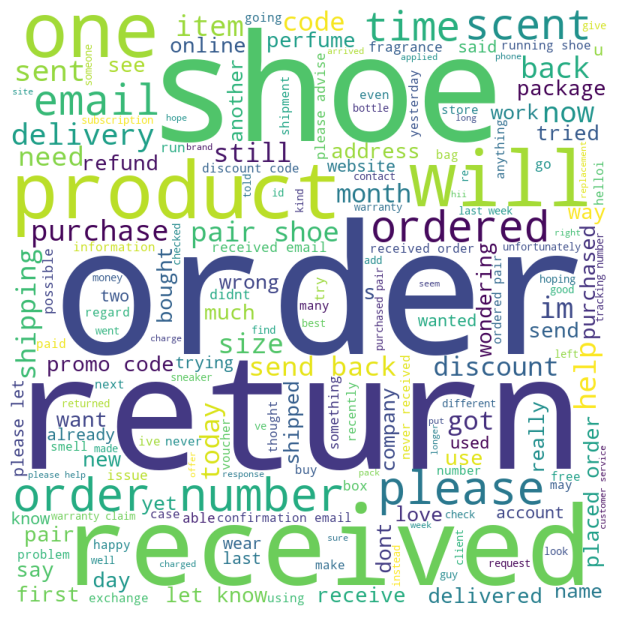

In [12]:
comment_words = ''

for val in DataFrame['Description']:
     
    # typecaste each val to string
    val = str(val)
    # split the value
    tokens = val.split()
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

#### Build target label
~ 5min

In [13]:
# Here to select which tags are sensitive
status_label = ['where-is-my-order','missing-items']
DataFrame['ask-status'] = 0
for index,row in DataFrame['tags'].items():
    cross_tag = set(status_label).intersection(row)
    # print(cross_tag)
    if len(cross_tag)!=0:
        DataFrame.loc[index,'ask-status']=1

In [14]:
DataFrame

,Description,tags,created_at,ask-status
0,Hi I ordered pair put relevant code free bag n...,"[category-1, missing-items, field-1456]",2020-03-15,1
1,I missing pair shoe order Could someone please...,"[missing-items, open-ticket]",2021-01-18,1
2,I didntget order,"[category-1, missing-items]",2019-08-01,1
3,Hello I ordered two NAMES one received two Cou...,"[category-1, missing-items, open-ticket, field...",2020-08-27,1
4,My shipment never delivered The tracking say d...,"[category-1, missing-items, open-ticket]",2019-07-21,1
...,...,...,...,...
1428,Subscription Do send back container month upon...,"[category-1, cancel-subscription, open-ticket]",2021-01-29,0
1429,PLEASE CANCEL ANY SUBSCRIPTION I HAVE PLEASE D...,"[category-1, cancel-subscription]",2019-10-16,0
1430,Return scent different one And cancel subscrip...,"[category-1, ticket, cancel-subscription]",2021-01-17,0
1431,Canceling subscription I need cancel subscript...,"[category-1, cancel-subscription, open-ticket]",2019-09-28,0


#### Vectorise the data
~ 10min


In [15]:
# Sample and shuffled
DataFrame = DataFrame.sample(5000,replace=True)
# DataFrame = DataFrame.sample(frac=1)

# balance sample, data augumentation
# DataFrame = DataFrame.groupby('ask-status').sample(n=5000,random_state=1,replace=True)


percentage_val = 0.8
percentage_test = 0.7
num_val = int(percentage_val * len(DataFrame))
num_test = int(percentage_test*(len(DataFrame)-num_val))
train,test = DataFrame[:num_val][['Description','ask-status']],DataFrame[num_val:][['Description','ask-status']]

training_sentences = np.array(train['Description'])
training_labels = np.array(train['ask-status'])

val_sentences = np.array(test['Description'][:num_test])
val_labels = np.array(test['ask-status'][:num_test])

test_sentences = np.array(test['Description'][num_test:])
test_labels = np.array(test['ask-status'][num_test:])

print(len(training_sentences))
print(len(val_sentences))
print(len(test_sentences))

4000
700
300


In [16]:
# the maxium vocaburaries 
vocab_size = 1000
# embeeding dimension
embedding_dim = 4
# maxium word length
max_length = 16
# cut the sentence from the post when over the @max_length
trunc_type = 'post'
# stand right
padding = 'post'
# missing vocab transfer to OOV
oov_tok = "<OOV>"


tokenier = Tokenizer(num_words= vocab_size,oov_token=oov_tok)
tokenier.fit_on_texts(training_sentences)
word_index = tokenier.word_index
# print(word_index)
sequences = tokenier.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, padding=padding,truncating=trunc_type,maxlen=max_length)

val_sequences = tokenier.texts_to_sequences(val_sentences)
val_padded = pad_sequences(val_sequences, padding=padding,truncating=trunc_type,maxlen=max_length)

test_sentences = tokenier.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sentences, padding=padding,truncating=trunc_type,maxlen=max_length)


#### Train Model
~ 1h
build model, tune hypermeters


In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length = max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10,return_sequences=True)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6,activation='relu'),
    tf.keras.layers.Dense(1,activation = 'sigmoid')
])


In [18]:
model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics=['accuracy','mae','mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 4)             4000      
                                                                 
 bidirectional (Bidirectiona  (None, 16, 20)           1200      
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense (Dense)               (None, 6)                 1926      
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 7,133
Trainable params: 7,133
Non-trainable params: 0
______________________________________________________

In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
num_epoches = 25
history = model.fit(padded,
          training_labels,
          epochs = num_epoches,
          validation_data = (val_padded,val_labels),
          callbacks=[callback])


Epoch 1/25


2023-02-19 23:27:22.252821: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


125/125 [==============================] - 2s 7ms/step - loss: 0.3753 - accuracy: 0.8763 - mae: 0.2411 - mse: 0.1160 - val_loss: 0.2148 - val_accuracy: 0.9071 - val_mae: 0.1443 - val_mse: 0.0645
Epoch 2/25
125/125 [==============================] - 0s 2ms/step - loss: 0.1369 - accuracy: 0.9517 - mae: 0.0902 - mse: 0.0410 - val_loss: 0.1063 - val_accuracy: 0.9657 - val_mae: 0.0745 - val_mse: 0.0316
Epoch 3/25
125/125 [==============================] - 0s 2ms/step - loss: 0.0601 - accuracy: 0.9800 - mae: 0.0383 - mse: 0.0164 - val_loss: 0.0770 - val_accuracy: 0.9700 - val_mae: 0.0426 - val_mse: 0.0224
Epoch 4/25
125/125 [==============================] - 0s 2ms/step - loss: 0.0326 - accuracy: 0.9880 - mae: 0.0196 - mse: 0.0090 - val_loss: 0.0497 - val_accuracy: 0.9814 - val_mae: 0.0240 - val_mse: 0.0129
Epoch 5/25
125/125 [==============================] - 0s 2ms/step - loss: 0.0162 - accuracy: 0.9962 - mae: 0.0095 - mse: 0.0037 - val_loss: 0.0457 - val_accuracy: 0.9871 - val_mae: 0.0177

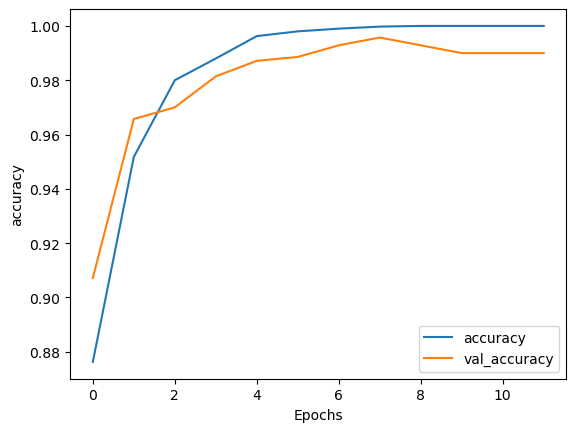

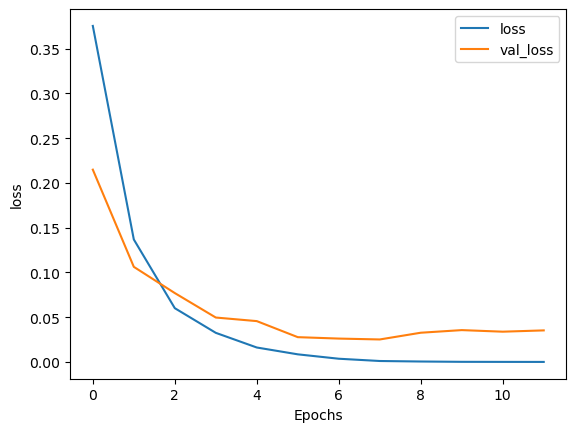

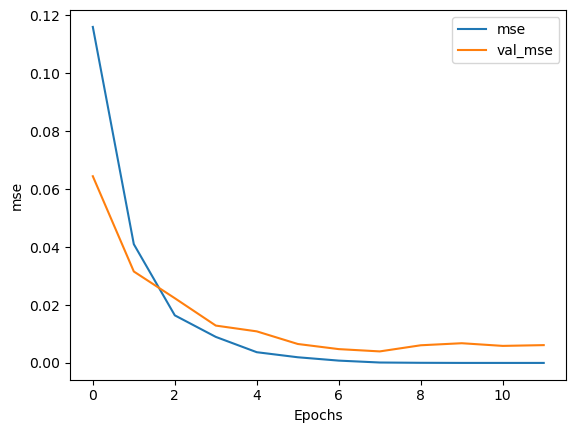

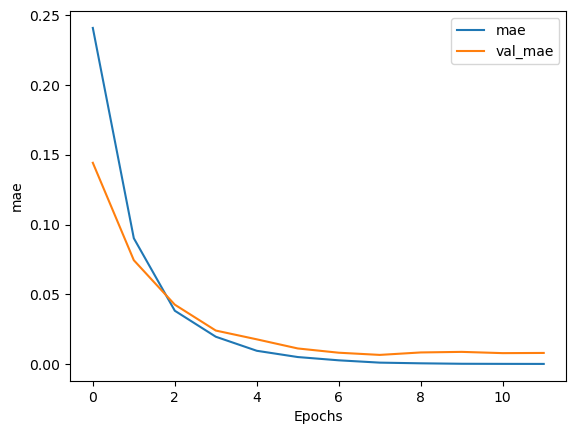

In [20]:
def plot_graphs(history,string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,'val_'+string])
    plt.show()
plot_graphs(history,'accuracy')
plot_graphs(history,'loss')
plot_graphs(history,'mse')
plot_graphs(history,'mae')

#### Visualization
~ 10 min

In [21]:
## https://projector.tensorflow.org/
e = model.layers[0]
weights = e.get_weights()[0]
reverse_word_index = tokenier.index_word
out_v = io.open('vecs.tsv','w',encoding='utf-8')
out_m = io.open('meta.tsv','w',encoding='utf-8')
for word_num in range(1,vocab_size):
    # print(word_num)
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word+"\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_m.close()
out_v.close()



#### Inference

Using different sampling methods or data augmentation could shows totally different confusion matrix

Here I am using balanced data automation, that is 50:50 sensitive vs nonsensitive data 

TP means the email is asking for the status and we detected it correctly.

TN means the email is not asking for the status, and we detected it correctly.

FP means the email is not asking for the status, but we detected it as ask for the status, so it is wrong

FN means the email is asking for the status, but we detected it is not asking for the status, it is wrong.

precision means there is a group of emails that are detected as positive, but how many emails are detected correctly.

recall means there is a group of emails that ask for the status, but how many emails have been detected.

accuracy means how many emails are correctly detected from this mess.

10/10 [==============================] - 0s 1ms/step
precision: 95.1219512195122 
 recall 100.0 
 accuracy 99.33333333333333


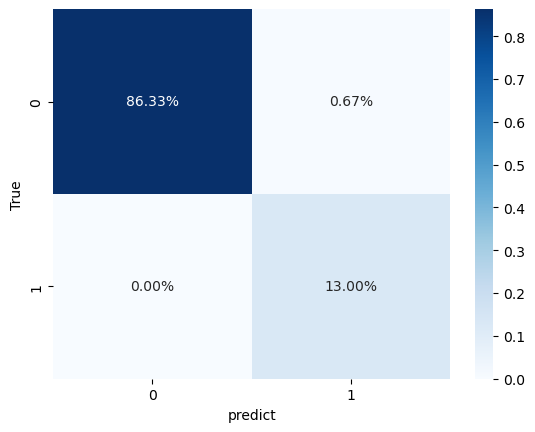

In [22]:
predict_test = model.predict(test_padded)
predict_test = predict_test>0.5
confusion_matrix = tf.math.confusion_matrix(test_labels,predict_test)
s = sns.heatmap(confusion_matrix/np.sum(confusion_matrix),annot=True, fmt='.2%', cmap='Blues')
s.set_xlabel('predict')
s.set_ylabel('True')
[[TN,FP],[FN,TP]] = np.array(confusion_matrix)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
accuracy = (TP+TN)/(TN+FP+FN+TP)
print('precision:',precision*100,"\n recall",recall*100,"\n accuracy",accuracy*100)